# Billards & Collisions

Simulation of a ball bouncing inside a circular boundary using event detection.

You can also find this example as a standalone Python file in the [GitHub repository](https://github.com/milanofthe/pathsim/blob/master/examples/examples_event/example_billards_sphere.py).

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Apply PathSim docs matplotlib style
plt.style.use('../pathsim_docs.mplstyle')

from pathsim import Simulation, Connection
from pathsim.blocks import Constant, Integrator, Scope
from pathsim.events import ZeroCrossingUp
from pathsim.solvers import RKBS32

In [22]:
# System parameters
g = 9.81   # gravity [m/s^2]
l = 1      # radius of circular boundary [m]

# Initial conditions
x0 = np.array([0.5, 0.5])  # initial position [m]
v0 = np.array([0, 0])      # initial velocity [m/s]

In [24]:
# Blocks for dynamics
cn = Constant(-g)                    # gravitational acceleration
ix = Integrator(x0)                  # position integrator
iv = Integrator(v0)                  # velocity integrator
sc = Scope(labels=["x", "y"])        # scope to record position

## Collision Detection and Response

The collision is detected using a zero-crossing event. The detection function computes the distance from the origin minus the boundary radius:

$$
f(x) = \|x\| - l
$$

When this function crosses zero from below (the ball reaches the boundary), the action function is triggered. The elastic reflection is computed as:

$$
v_{\text{new}} = v - 2(v \cdot n)n
$$

where $n = x / \|x\|$ is the outward normal at the collision point.

In [27]:
# Collision event functions
def bounce_detect(_):
    """Detect when ball reaches boundary."""
    x = ix.engine.get()
    return np.linalg.norm(x) - l 

def bounce_act(_):
    """Reflect velocity elastically off boundary."""
    v = iv.engine.get()
    x = ix.engine.get()
    n = x / np.linalg.norm(x)  # outward normal
    iv.engine.set(v - 2 * np.dot(v, n) * n)  # reflect velocity
    ix.engine.set(l * n)  # ensure position is exactly on boundary

In [29]:
# Simulation definition
sim = Simulation(
    blocks=[ix, iv, sc, cn],
    connections=[
        Connection(cn, iv[1]),         # gravity -> velocity y-component
        Connection(iv[0,1], ix[0,1]),  # velocity -> position
        Connection(ix[0,1], sc[0,1]),  # position -> scope
    ],
    events=[
        ZeroCrossingUp(
            func_evt=bounce_detect, 
            func_act=bounce_act,
        ),
    ],
    Solver=RKBS32,
    dt_max=0.01
)

10:35:08 - INFO - LOGGING (log: True)
10:35:08 - INFO - BLOCKS (total: 4, dynamic: 2, static: 2, eventful: 0)
10:35:08 - INFO - GRAPH (nodes: 4, edges: 3, alg. depth: 1, loop depth: 0, runtime: 0.024ms)


In [31]:
# Run the simulation
sim.run(7)

10:35:10 - INFO - STARTING -> TRANSIENT (Duration: 7.00s)
10:35:10 - INFO - --------------------   1% | 0.0s<0.2s | 3965.9 it/s
10:35:10 - INFO - ####----------------  20% | 0.0s<0.1s | 10719.7 it/s
10:35:10 - INFO - ########------------  40% | 0.1s<0.2s | 5798.9 it/s
10:35:10 - INFO - ############--------  60% | 0.1s<0.0s | 10649.7 it/s
10:35:10 - INFO - ################----  80% | 0.1s<0.0s | 8253.2 it/s
10:35:10 - INFO - #################### 100% | 0.1s<--:-- | 10653.1 it/s
10:35:10 - INFO - FINISHED -> TRANSIENT (total steps: 818, successful: 778, runtime: 119.14 ms)


{'total_steps': 818, 'successful_steps': 778, 'runtime_ms': 119.14179999439511}

Let's visualize the results. First, we plot the x and y coordinates over time:

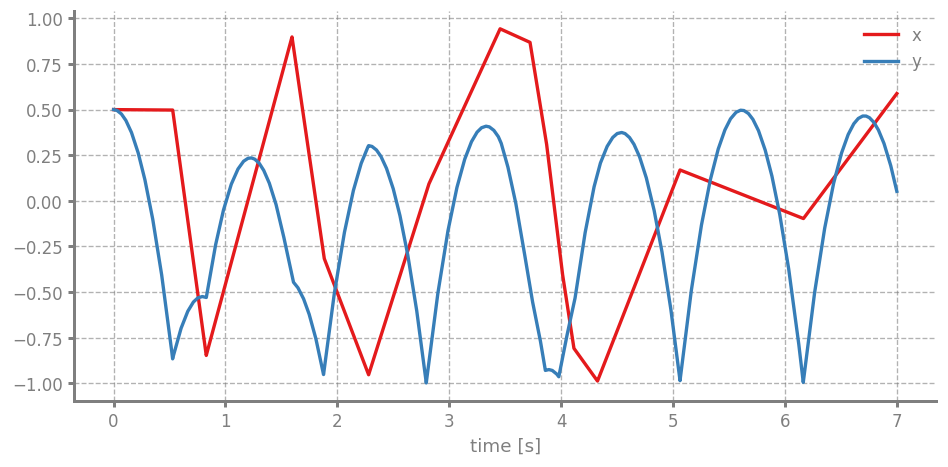

In [34]:
# Plot position components over time
sc.plot();

The 2D trajectory shows the ball bouncing inside the circular boundary. We overlay the boundary circle for reference:

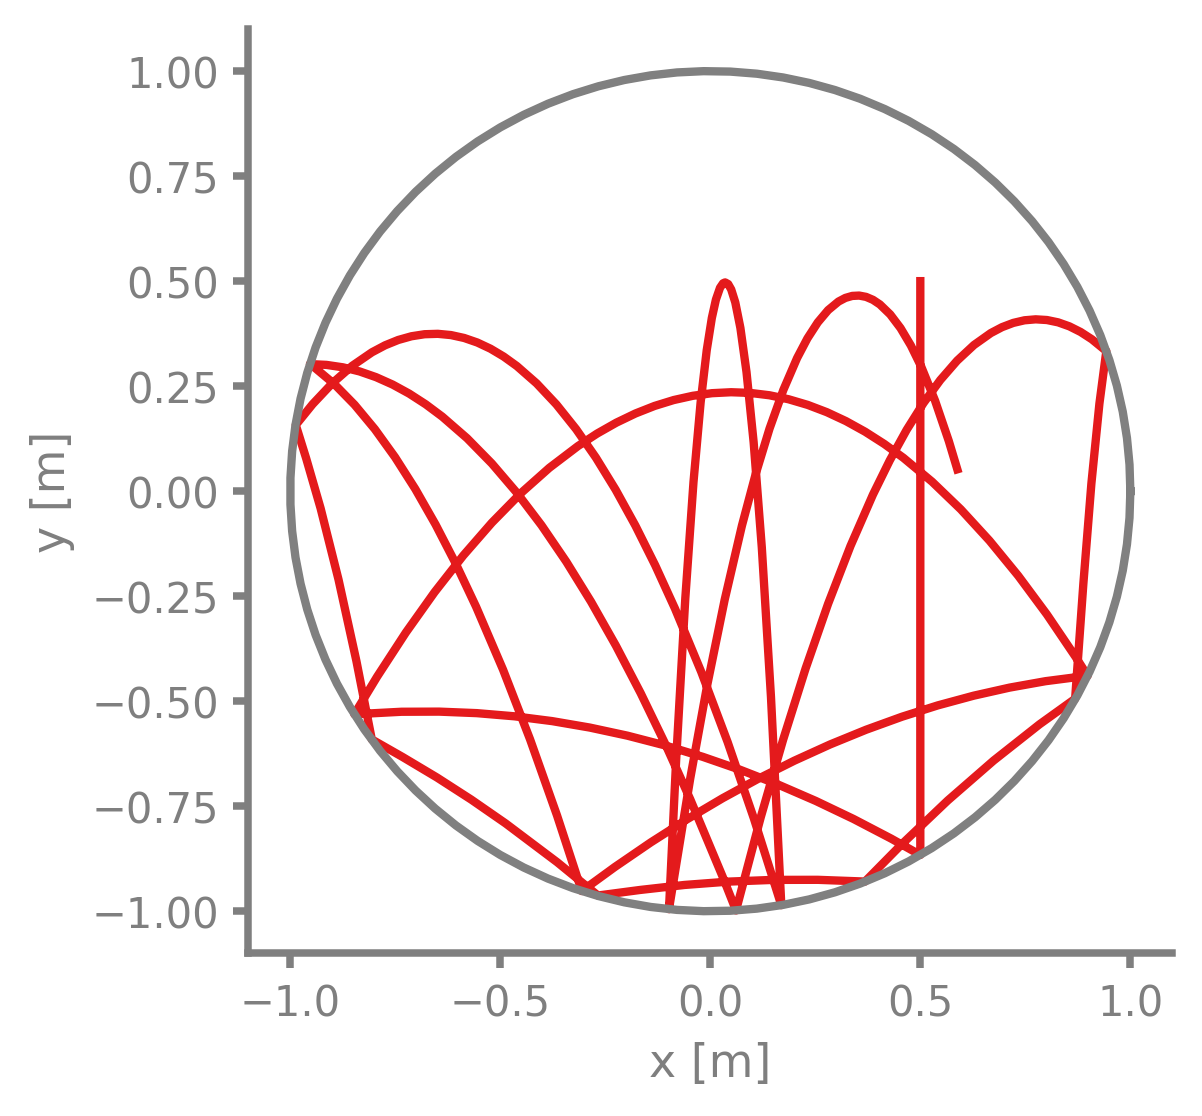

In [41]:
# Plot 2D trajectory with boundary
t, (x, y) = sc.read()

fig, ax = plt.subplots()
ax.plot(x, y)

# Draw circular boundary
ang = np.linspace(0, 2*np.pi, 100)
ax.plot(np.cos(ang), np.sin(ang), color="grey", linewidth=2)
ax.set_aspect('equal')
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]");